# ElasticNet Regression Model Optimization and Training

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_predict
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

OUTPUT_DIR = Path('../../Outputs')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Set random seed for reproducibility
np.random.seed(42)

In [2]:
# Load training data
X_train = pd.read_csv('../../Data/X_train.csv')
y_train = pd.read_csv('../../Data/y_train.csv')

print("Training Data Shape:")
print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")
print("\nFirst few rows of X_train:")
print(X_train.head())

Training Data Shape:
X_train: (400, 9)
y_train: (400, 1)

First few rows of X_train:
  User_ID  Age  Gender  Daily_Screen_Time(hrs)  Sleep_Quality(1-10)  \
0    U297   23  Female                     5.0                  5.0   
1    U221   23   Other                     5.2                  7.0   
2    U001   44    Male                     3.1                  7.0   
3    U256   33  Female                     5.9                  4.0   
4    U336   27    Male                     3.8                  8.0   

   Stress_Level(1-10)  Days_Without_Social_Media  Exercise_Frequency(week)  \
0                 7.0                        2.0                       4.0   
1                 6.0                        5.0                       1.0   
2                 6.0                        2.0                       5.0   
3                 7.0                        0.0                       3.0   
4                 6.0                        6.0                       4.0   

  Social_Media_Plat

In [3]:
# Check for missing values
print("Missing values in X_train:")
print(X_train.isnull().sum())
print("\nData types:")
print(X_train.dtypes)

# Print number of samples/features
print(f"Total training samples: {X_train.shape[0]}")
print(f"Number of features: {X_train.shape[1]}")

Missing values in X_train:
User_ID                      0
Age                          0
Gender                       0
Daily_Screen_Time(hrs)       0
Sleep_Quality(1-10)          0
Stress_Level(1-10)           0
Days_Without_Social_Media    0
Exercise_Frequency(week)     0
Social_Media_Platform        0
dtype: int64

Data types:
User_ID                       object
Age                            int64
Gender                        object
Daily_Screen_Time(hrs)       float64
Sleep_Quality(1-10)          float64
Stress_Level(1-10)           float64
Days_Without_Social_Media    float64
Exercise_Frequency(week)     float64
Social_Media_Platform         object
dtype: object
Total training samples: 400
Number of features: 9


### Data Preprocessing

Utilizes ColumnTransformer to create a preprocessing step for our pipeline. Identifies categorical variables and uses OrdinalEncoder to process them. Drops applicable columns.

In [4]:
# preprocessing pipeline

# Drop User_ID
drop_cols = []
if "User_ID" in X_train.columns:
    drop_cols.append("User_ID")

# Encode categorical variables, standardize numeric variables (feature scaling)
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()
numeric_features = X_train.select_dtypes(exclude=['object']).columns.tolist()

# Set up preprocessing object
preprocessor = ColumnTransformer(
    transformers=[
        ('categorical', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorical_features),
        ('drop', 'drop', drop_cols),
        ('numeric', StandardScaler(), numeric_features)
    ]
)

### Model Setup

Creates a pipeline to execute preprocessing steps and model training using an ElasticNet object. Defines the hyperparameter grid, and creates a GridSearchCV object with 5-fold cross validation that scores with negative mean squared error.

In [5]:
# To be called by cross-validation object
pipe = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('elasticnet', ElasticNet(random_state=42, max_iter=10000))
])

# Define hyperparameter grid
param_grid = {
    'elasticnet__alpha': [0.001, 0.01, 0.1, 0.5, 1, 5, 10],
    'elasticnet__l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
}

# GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(
    pipe,
    param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

### Model Training and Evaluation

Fits grid_search object to the training set, and outputs the best parameters and some training metrics (MSE, RMSE, MAE, R²).

In [6]:
# Train the model
grid_search.fit(X_train, y_train)
print(f"Best alpha: {grid_search.best_params_['elasticnet__alpha']}")
print(f"Best l1_ratio: {grid_search.best_params_['elasticnet__l1_ratio']}")
print(f"Best CV MSE: {-grid_search.best_score_:.4f}")

# Get best model and generate cross-validation predictions
best_model = grid_search.best_estimator_

# Get cross-validation predictions for the entire training set
y_pred_cv = cross_val_predict(best_model, X_train, y_train, cv=5)

# Calculate cross-validation metrics
mse = mean_squared_error(y_train, y_pred_cv)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_train, y_pred_cv)
r2 = r2_score(y_train, y_pred_cv)

print("\nCross-Validation Performance (5-fold):")
print(f"MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE:  {mae:.4f}")
print(f"R²:   {r2:.4f}")

Fitting 5 folds for each of 35 candidates, totalling 175 fits


Best alpha: 0.1
Best l1_ratio: 0.1
Best CV MSE: 0.8906

Cross-Validation Performance (5-fold):
MSE:  0.8906
RMSE: 0.9437
MAE:  0.7615
R²:   0.6257


### Model Performance Analysis

Generates several plots, and outputs the best parameters and performance metrics. The following information is included in this analysis:
- Horizontal bar chart analysis of feature coefficients
- Scatterplot comparing predicted happiness scores to the actual happiness score in the validation set.
- Best model's optimal hyperparameters and cross-validation performance metrics

Feature Coefficients (sorted by absolute value):
                     Feature  Coefficient
6  Days_Without_Social_Media    -0.640516
5         Stress_Level(1-10)     0.410835
4        Sleep_Quality(1-10)    -0.274656
7   Exercise_Frequency(week)     0.070449
3     Daily_Screen_Time(hrs)     0.068006
8      Social_Media_Platform     0.022817
2                     Gender     0.016731
0                    User_ID    -0.000441
1                        Age     0.000000


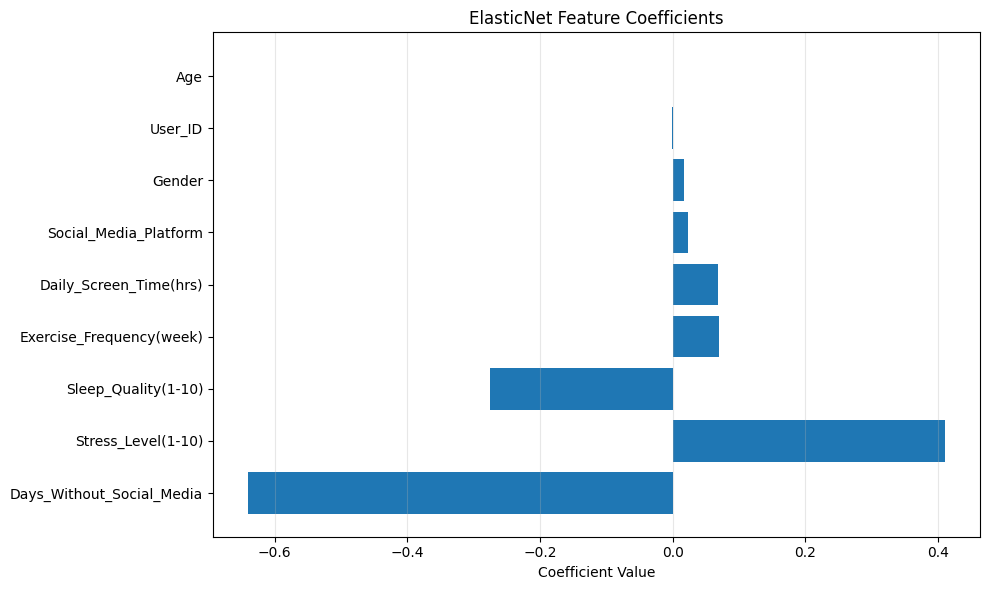


Features with non-zero coefficients: 8/9


In [7]:
# Analyze feature coefficients
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': best_model.named_steps["elasticnet"].coef_ # can't directly access coefs from pipeline
}).sort_values('Coefficient', key=abs, ascending=False)

print("Feature Coefficients (sorted by absolute value):")
print(feature_importance)

# Visualize coefficients
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Coefficient'])
plt.xlabel('Coefficient Value')
plt.title('ElasticNet Feature Coefficients')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "elasticnet_feature_coefficients.png", dpi=300, bbox_inches='tight')
plt.show()

# Count non-zero coefficients
non_zero = np.sum(best_model.named_steps["elasticnet"].coef_ != 0)
print(f"\nFeatures with non-zero coefficients: {non_zero}/{len(feature_importance)}")

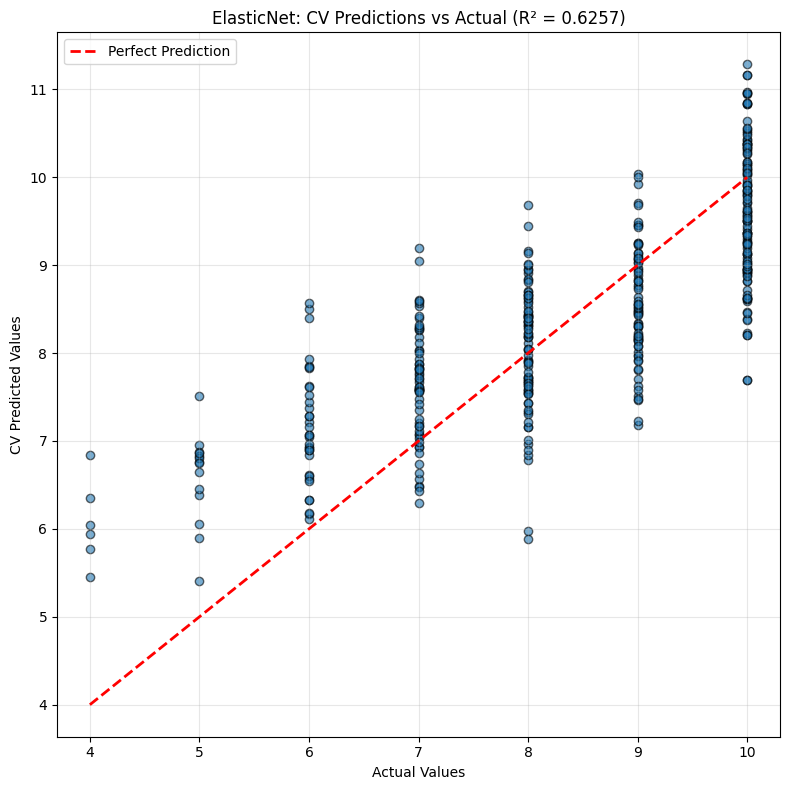

In [8]:
# Plot cross-validation predictions vs actual
plt.figure(figsize=(8, 8))
plt.scatter(y_train, y_pred_cv, alpha=0.6, edgecolors='k')
plt.plot([y_train.min(), y_train.max()],
         [y_train.min(), y_train.max()],
         'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Values')
plt.ylabel('CV Predicted Values')
plt.title(f'ElasticNet: CV Predictions vs Actual (R² = {r2:.4f})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "elasticnet_cv_predictions_vs_actual.png", dpi=300, bbox_inches='tight')
plt.show()

In [9]:
# The best model has already been trained on the full training set via GridSearchCV
# Re-fit the final model to ensure it's trained on all data
best_model.fit(X_train, y_train)

print(f"\nOptimal Hyperparameters:")
print(f"  - Alpha: {grid_search.best_params_['elasticnet__alpha']}")
print(f"  - L1 Ratio: {grid_search.best_params_['elasticnet__l1_ratio']}")
print(f"\nCross-Validation Performance:")
print(f"  - MSE: {mse:.4f}")
print(f"  - RMSE: {rmse:.4f}")
print(f"  - R²: {r2:.4f}")


Optimal Hyperparameters:
  - Alpha: 0.1
  - L1 Ratio: 0.1

Cross-Validation Performance:
  - MSE: 0.8906
  - RMSE: 0.9437
  - R²: 0.6257
